Task:
Take the MNIST dataset in the keras.datasets API

Put the data into a TFrecord format in multiple files. Then train a keras model that uses tf's Data API to preprocess the data concurrently as the model is being trained.

Print a graph of the loss.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np

In [ ]:
import tensorflow_datasets as tfds
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
ds = tfds.load('mnist', shuffle_files=True, as_supervised=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
ds['test'].cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=10000>

In [ ]:
ds_splits = ["train", "test"]

In [ ]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_array(array):
  array = tf.io.serialize_tensor(array)
  return array

In [ ]:
for d in ds_splits:
  print("saving {}".format(d))
  subset = ds[d]

  filename = d+".tfrecords"
  writer = tf.io.TFRecordWriter(filename)
  count = 0
  for image, label in subset:
    data={
        'height': _int64_feature(28),
        'width': _int64_feature(28),
        'depth': _int64_feature(1),
        'label': _int64_feature(label),
        'image_raw':_bytes_feature(serialize_array(image))
        }

    out = tf.train.Example(features=tf.train.Features(feature=data))
    writer.write(out.SerializeToString())
    count +=1
  writer.close()
  print(count)

saving train
60000
saving test
10000


In [ ]:
def parse_tfr_elem(element):
  parse_dict = {
      'height': tf.io.FixedLenFeature([], tf.int64),
      'width':tf.io.FixedLenFeature([], tf.int64),
      'label':tf.io.FixedLenFeature([], tf.int64),
      'depth':tf.io.FixedLenFeature([], tf.int64),
      'image_raw' : tf.io.FixedLenFeature([], tf.string)
  }
  example_message = tf.io.parse_single_example(element, parse_dict)

  img_raw = example_message['image_raw']
  height = example_message['height']
  width = example_message['width']
  depth = example_message['depth']
  label = example_message['label']
  
  feature = tf.io.parse_tensor(img_raw, out_type=tf.uint8)
  feature = tf.reshape(feature, shape=[height,width,depth])
  return (feature, label)

In [ ]:
def get_dataset(filename, set_type):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filename)
    
    dataset = dataset.with_options(
        ignore_order
    )  

    dataset = dataset.map(
        parse_tfr_elem, num_parallel_calls=AUTOTUNE
    )

    dataset = dataset.shuffle(2048, reshuffle_each_iteration=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.repeat() if set_type =='train' else dataset 
    return dataset

In [ ]:
BATCH_SIZE = 32

In [ ]:
tfr_dataset = get_dataset('train.tfrecords', "train")

In [ ]:
for sample in tfr_dataset.take(1):
  print(sample)

(<tf.Tensor: shape=(32, 28, 28, 1), dtype=uint8, numpy=
array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],


In [ ]:
def my_neural_network():
  input_ = keras.layers.Input(shape = [28,28, 1])
  flatten = keras.layers.Flatten()(input_)
  hidden1 = keras.layers.Dense(30, activation = 'relu')(flatten)
  hidden2 = keras.layers.Dense(30, activation = 'relu')(hidden1)
  hidden3 = keras.layers.Dense(30, activation = 'relu')(hidden2)
  concat = keras.layers.concatenate([flatten, hidden3])
  output = keras.layers.Dense(10, activation = 'softmax')(concat)

  model_1 = keras.models.Model(inputs = [input_], outputs = [output])
  model_1.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])
  return model_1

In [ ]:
model = my_neural_network()

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten_2 (Flatten)            (None, 784)          0           ['input_3[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 30)           23550       ['flatten_2[0][0]']              
                                                                                                  
 dense_9 (Dense)                (None, 30)           930         ['dense_8[0][0]']                
                                                                                            

In [ ]:
history = model.fit(tfr_dataset, steps_per_epoch=60000//BATCH_SIZE, epochs = 20)

Epoch 1/20
1875/1875 [==============================] - 7s 3ms/step - loss: 316.8770 - accuracy: 0.8429
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 261.1919 - accuracy: 0.8684
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 253.2968 - accuracy: 0.8725
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 244.9316 - accuracy: 0.8746
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 240.4873 - accuracy: 0.8782
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 239.7813 - accuracy: 0.8789
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 237.4817 - accuracy: 0.8800
Epoch 8/20
1875/1875 [==============================] - 5s 3ms/step - loss: 237.6044 - accuracy: 0.8810
Epoch 9/20
1875/1875 [==============================] - 5s 3ms/step - loss: 229.5136 - accuracy: 0.8830
Epoch 10/20
1875/1875 [==============================] - 5s 3ms/

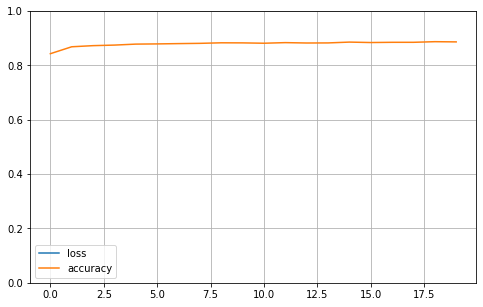

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()